## Import and setup

In [1]:
# Choose a gpu to run on
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'True'

# automatic reloading of submodules for active development.
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import socket
import time
from typing import Callable, Tuple

from hydra import initialize, compose
from hydra.utils import instantiate, call
from hydra.core.global_hydra import GlobalHydra

from absl import logging as log
import numpy as np
import tqdm
import jax
import jax.numpy as jnp
from annealed_flow_transport.distributions import WhitenedDistributionWrapper
from annealed_flow_transport.loggers_pl import LoggerCollection
from annealed_flow_transport import aft
from annealed_flow_transport import craft
from annealed_flow_transport import densities
from annealed_flow_transport import distributions
from annealed_flow_transport import flow_transport
from annealed_flow_transport import flows
from annealed_flow_transport import markov_kernel
from annealed_flow_transport import samplers
from annealed_flow_transport import serialize
from annealed_flow_transport import smc
from annealed_flow_transport import snf
from annealed_flow_transport import vi
from annealed_flow_transport.resampling import simple_resampling
import annealed_flow_transport.aft_types as tp
import chex
import haiku as hk
import optax
from hydra.utils import instantiate
from omegaconf import OmegaConf

from annealed_flow_transport.reference_vi import get_variational_approx


# Type defs.
Array = tp.Array
OptState = tp.OptState
UpdateFn = tp.UpdateFn
FlowParams = tp.FlowParams
FlowApply = tp.FlowApply
LogDensityByStep = tp.LogDensityByStep
RandomKey = tp.RandomKey
AcceptanceTuple = tp.AcceptanceTuple
FreeEnergyAndGrad = tp.FreeEnergyAndGrad
FreeEnergyEval = tp.FreeEnergyEval
MarkovKernelApply = tp.MarkovKernelApply
SamplesTuple = tp.SamplesTuple
LogWeightsTuple = tp.LogWeightsTuple
VfesTuple = tp.VfesTuple
InitialSampler = tp.InitialSampler
LogDensityNoStep = tp.LogDensityNoStep
assert_equal_shape = chex.assert_equal_shape
AlgoResultsTuple = tp.AlgoResultsTuple

2024-01-30 16:59:02.615098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 16:59:02.615142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 16:59:02.615174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 16:59:04.491474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/data/ziz/not-backed-up/anphilli/miniconda3/envs/aft/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  

In [3]:
def get_optimizer(initial_learning_rate: float, boundaries_and_scales):
    """Get an optimizer possibly with learning rate schedule."""
    if boundaries_and_scales is None:
        return optax.adam(initial_learning_rate)
    else:
        schedule_fn = optax.piecewise_constant_schedule(
            initial_learning_rate, boundaries_and_scales
        )
        opt = optax.chain(
            optax.scale_by_adam(),
            optax.scale_by_schedule(schedule_fn),
            optax.scale(-1.0),
        )
        return opt


def value_or_none(value: str, config):
    if value in config:
        return config[value]
    else:
        return None


def is_flow_algorithm(algo_name):
    return algo_name in ("aft", "vi", "craft", "snf")


def is_markov_algorithm(algo_name):
    return algo_name in ("aft", "craft", "snf", "smc")


def is_annealing_algorithm(algo_name):
    return algo_name in ("aft", "craft", "snf", "smc")


def boundaries_and_scales(method, config):
    if method + "_boundaries" in config:
        if method == "snf":
            snf_boundaries_and_scales = {}
            for key, value in zip(config.snf_boundaries, config.snf_scales):
                snf_boundaries_and_scales[key] = value
            return craft_boundaries_and_scales
        if method == "craft":
            craft_boundaries_and_scales = {}
            for key, value in zip(config.craft_boundaries, config.craft_scales):
                craft_boundaries_and_scales[key] = value
            return craft_boundaries_and_scales
    else:
        return None


def prepare_outer_loop(
    initial_sampler: InitialSampler,
    initial_log_density: Callable[[Array], Array],
    final_log_density: Callable[[Array], Array],
    flow_func: Callable[[Array], Tuple[Array, Array]],
    config,
    key,
    logger,
) -> AlgoResultsTuple:
    """Shared code outer loops then calls the outer loops themselves.

    Args:
      initial_sampler: Function for producing initial sample.
      initial_log_density: Function for evaluating initial log density.
      final_log_density: Function for evaluating final log density.
      flow_func: Flow function to pass to Haiku transform.
      config: experiment configuration.
    Returns:
      An AlgoResultsTuple containing the experiment results.

    """
    num_temps = config.base_steps * config.steps_mult + 1
    if is_annealing_algorithm(config.algo):
        density_by_step = flow_transport.GeometricAnnealingSchedule(
            initial_log_density, final_log_density, num_temps
        )
    if is_markov_algorithm(config.algo):
        markov_kernel_by_step = markov_kernel.MarkovTransitionKernel(
            config.mcmc_config, density_by_step, num_temps
        )

    flow_forward_fn = hk.without_apply_rng(hk.transform(flow_func))
    key, subkey = jax.random.split(key)
    single_normal_sample = initial_sampler(
        subkey, config.batch_size, (config.num_dims,)
    )
    key, subkey = jax.random.split(key)
    flow_init_params = flow_forward_fn.init(subkey, single_normal_sample)

    if value_or_none("save_checkpoint", config):

        def save_checkpoint(params):
            return serialize.save_checkpoint(config.params_filename, params)

    else:
        save_checkpoint = None

    nb_params = sum(x.size for x in jax.tree_util.tree_leaves(flow_init_params))
    log.info(f"Number of parameters: {nb_params * config.base_steps * config.steps_mult}")
    if logger:
        logger.log_metrics({"nb_params": nb_params * config.base_steps * config.steps_mult}, 0)

    if config.algo == "vi":  # Note converted to stateful
        # Add a save_checkpoint function here to enable saving final state.
        opt = get_optimizer(config.optimization_config.vi_step_size, None)
        opt_init_state = opt.init(flow_init_params)
        results = vi.outer_loop_vi(
            initial_sampler=initial_sampler,
            opt_update=opt.update,
            opt_init_state=opt_init_state,
            flow_init_params=flow_init_params,
            flow_apply=flow_forward_fn.apply,
            key=key,
            initial_log_density=initial_log_density,
            final_log_density=final_log_density,
            config=config,
            save_checkpoint=save_checkpoint,
        )
    elif config.algo == "smc":
        # eval_sampler = jax.jit(
        #     partial(
        #         smc.fast_outer_loop_smc,
        #         density_by_step=density_by_step,
        #         initial_sampler=initial_sampler,
        #         markov_kernel_by_step=markov_kernel_by_step,
        #         config=config,
        #         density_state=0,
        #     )
        # )
        # rng = jax.random.PRNGKey(config.seed)
        # log_Z = np.zeros(config.num_smc_iters)
        # start_time = time.time()
        # for i in tqdm.tqdm(
        #     range(config.num_smc_iters), disable=(not config.progress_bars)
        # ):
        #     rng, rng_ = jax.random.split(rng)
        #     results, sampling_density_calls = eval_sampler(key=rng_)
        #     log_Z[i] = results.log_normalizer_estimate
        # end_time = time.time()
        # Save normalising constant estimates (comment out when not doing a final evaluation run)
        # if config.save_samples:
        #     np.savetxt(
        #         f"/data/ziz/not-backed-up/anphilli/diffusion_smc/{config.group}/{config.name}_smchmcvi_{config.base_steps * config.steps_mult}_{config.seed}.csv",
        #         log_Z,
        #     )
        # if logger:
        #     logger.log_metrics(
        #         {
        #             "sampling_time": (end_time - start_time) / config.num_smc_iters,
        #             "sampling_density_calls": sampling_density_calls,
        #         },
        #         step=0,
        #     )
        #     logger.log_metrics(
        #         {"final_log_Z": np.mean(log_Z), "var_final_log_Z": np.var(log_Z)}, 0
        #     )
        results, _ = smc.outer_loop_smc(
            density_by_step=density_by_step,
            initial_sampler=initial_sampler,
            markov_kernel_by_step=markov_kernel_by_step,
            key=key,
            config=config,
            logger=logger,
            density_state=0,
        )
    elif config.algo == "snf":  # Not converted to stateful
        opt = get_optimizer(
            config.optimization_config.snf_step_size,
            boundaries_and_scales("snf", config.optimization_config),
        )
        log_step_output = None
        results = snf.outer_loop_snf(
            flow_init_params=flow_init_params,
            flow_apply=flow_forward_fn.apply,
            density_by_step=density_by_step,
            markov_kernel_by_step=markov_kernel_by_step,
            initial_sampler=initial_sampler,
            key=key,
            opt=opt,
            config=config,
            log_step_output=log_step_output,
            save_checkpoint=save_checkpoint,
            logger=logger,
        )
    elif config.algo == "aft":  # Not converted to stateful
        opt = get_optimizer(config.optimization_config.aft_step_size, None)
        opt_init_state = opt.init(flow_init_params)
        # Add a log_step_output function here to enable non-trivial step logging.
        log_step_output = None
        results = aft.outer_loop_aft(
            opt_update=opt.update,
            opt_init_state=opt_init_state,
            flow_init_params=flow_init_params,
            flow_apply=flow_forward_fn.apply,
            density_by_step=density_by_step,
            markov_kernel_by_step=markov_kernel_by_step,
            initial_sampler=initial_sampler,
            key=key,
            config=config,
            log_step_output=log_step_output,
        )
    elif config.algo == "craft":
        opt = get_optimizer(
            config.optimization_config.craft_step_size,
            boundaries_and_scales("craft", config.optimization_config),
        )
        opt_init_state = opt.init(flow_init_params)
        log_step_output = None
        results, transition_params = craft.outer_loop_craft(
            opt_update=opt.update,
            opt_init_state=opt_init_state,
            flow_init_params=flow_init_params,
            flow_apply=flow_forward_fn.apply,
            flow_inv_apply=None,
            density_by_step=density_by_step,
            markov_kernel_by_step=markov_kernel_by_step,
            initial_sampler=initial_sampler,
            key=key,
            density_state=0,
            config=config,
            log_step_output=log_step_output,
            save_checkpoint=save_checkpoint,
            logger=logger,
        )
        eval_sampler = jax.jit(
            partial(
                craft.craft_evaluation_loop,
                transition_params=transition_params,
                flow_apply=flow_forward_fn.apply,
                markov_kernel_apply=markov_kernel_by_step,
                initial_sampler=initial_sampler,
                log_density=density_by_step,
                density_state=0,
                config=config,
            )
        )
        rng = jax.random.PRNGKey(config.seed)
        results, sampling_density_calls = eval_sampler(key=rng)
        # log_Z = np.zeros(config.num_smc_iters)
        # start_time = time.time()
        # for i in tqdm.tqdm(
        #     range(config.num_smc_iters), disable=(not config.progress_bars)
        # ):
        #     rng, rng_ = jax.random.split(rng)
        #     eval_results, sampling_density_calls = eval_sampler(key=rng_)
        #     log_Z[i] = eval_results.log_normalizer_estimate
        # end_time = time.time()
        # # Save normalising constant estimates (comment out when not doing a final evaluation run)
        # if config.save_samples:
        #     np.savetxt(
        #         f"/data/ziz/not-backed-up/anphilli/diffusion_smc/{config.group}/{config.name}_crafthmcvi_{config.base_steps * config.steps_mult}_{config.seed}.csv",
        #         log_Z,
        #     )
        # if logger:
        #     logger.log_metrics(
        #         {
        #             "sampling_time": (end_time - start_time) / config.num_smc_iters,
        #             "sampling_density_calls": sampling_density_calls,
        #         },
        #         step=0,
        #     )
        #     logger.log_metrics(
        #         {"final_log_Z": np.mean(log_Z), "var_final_log_Z": np.var(log_Z)}, 0
        #     )

    else:
        raise NotImplementedError
    return results

## Get config

In [4]:
GlobalHydra.instance().clear()
initialize(config_path="../config")
config=compose(config_name='main', overrides=["experiment=difficult_gaussian", "steps_mult=8", 'algo=smc', 'batch_size=10000', 'use_vi_approx=False'])

In [21]:
loc=6.5
means = jnp.array([[-loc], [loc]])
# means = jnp.array([[-1.0], [4.0]])
covs = jnp.array([[[0.1]], [[1]]])
weights = jnp.array([0.8, 0.2])

In [22]:
key = jax.random.PRNGKey(config.seed)

log_density_initial = getattr(densities, config.initial_config.density)(
    config.initial_config, (config.num_dims,), is_target=False
)
# log_density_final = getattr(distributions, config.final_config.density)(
#     is_target=True
# )
log_density_final = distributions.SeparatedMixture1D(means=means, covs=covs, weights=weights, dim=1, is_target=True)

if config.use_vi_approx:
    key, key_ = jax.random.split(key)
    vi_params = get_variational_approx(config, key_, log_density_final)
    log_density_final = WhitenedDistributionWrapper(
        log_density_final,
        vi_params["Variational"]["means"],
        vi_params["Variational"]["scales"],
    )

initial_sampler = getattr(samplers, config.initial_sampler_config.initial_sampler)(
    config.initial_sampler_config
)


if config.flow_config.type == "ComposedFlows":
    config.flow_config.flow_configs = [
        config.flow_config.base_flow_config
    ] * config.flow_config.num_stack

def flow_func(x):
    if is_flow_algorithm(config.algo):
        flow = getattr(flows, config.flow_config.type)(config.flow_config)
        return flow(x)
    else:
        return None

results = prepare_outer_loop(
    initial_sampler,
    log_density_initial,
    log_density_final,
    flow_func,
    config,
    key,
    None,
)

In [23]:
import pandas as pd
key, subkey = jax.random.split(key)
final_samples = simple_resampling(key=subkey, log_weights=results.test_log_weights, samples=results.test_samples)[0]
vars = [f"x{i}" for i in range(final_samples.shape[-1])]
final_samples_pd = pd.DataFrame(final_samples, columns=vars)
target_samples = log_density_final.sample(jax.random.split(key)[0], num_samples=int(1e5))
target_samples_pd = pd.DataFrame(target_samples, columns=vars)
# np.savetxt('/vols/ziz/not-backed-up/anphilli/diffusion_smc/samples/smc.csv', final_samples)

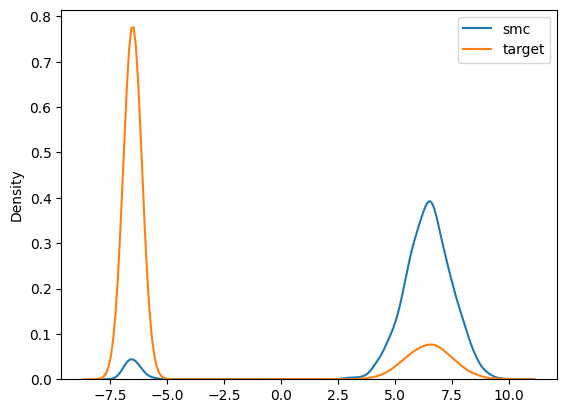

In [24]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig = plt.figure()
ax = plt.gca()
sns.kdeplot(final_samples[:, 0], ax=ax, bw_adjust=0.5, label='smc')
sns.kdeplot(target_samples[:, 0], ax=ax, bw_adjust=0.5, label='target')
plt.legend()
plt.show()

# fig = plt.figure()
# plt.hist(final_samples[:, 0], bins=100, alpha=0.3, label='smc')
# plt.hist(target_samples[:, 0],  bins=100, alpha=0.3, label='target')
# plt.legend()
# plt.show()